<a href="https://colab.research.google.com/github/Yi-Wei-Lin/Tibame_ML_20210602/blob/main/Cabbage_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Recurrent Neural Network



# Part 1 - Data Preprocessing

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Importing the training set
dataset_train = pd.read_excel('Cabbage_train.xlsx')
# dataset_train = dataset_train.dropna().loc[dataset_train.dropna()["Market"]=="台北一"]
training_set = dataset_train.iloc[:, 6:7].values



# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
time_step = 60
data_len = len(training_set_scaled)
for i in range(time_step, data_len):
    X_train.append(training_set_scaled[i-time_step : i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [35]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, test_size=0.1)
dataset_train

,Date,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
0,2000-01-02,台北一,LA1 甘藍 初秋,11.0,8.0,5.0,8.9,192029,1,7,2000,0
1,2000-01-03,台北一,LA1 甘藍 初秋,9.0,7.0,4.0,7.2,174270,1,1,2000,0
2,2000-01-04,台北一,LA1 甘藍 初秋,8.0,6.0,3.0,6.7,125426,1,2,2000,0
3,2000-01-05,台北一,LA1 甘藍 初秋,10.0,7.0,4.0,7.1,119318,1,3,2000,0
4,2000-01-06,台北一,LA1 甘藍 初秋,9.0,7.0,5.0,6.8,118178,1,4,2000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6362,2020-12-26,台北一,LA1 甘藍 初秋,31.1,25.3,14.9,24.4,163218,12,6,2020,0
6363,2020-12-27,台北一,LA1 甘藍 初秋,32.3,24.8,16.7,24.7,154663,12,7,2020,0
6364,2020-12-29,台北一,LA1 甘藍 初秋,32.0,26.2,15.3,25.2,171005,12,2,2020,0
6365,2020-12-30,台北一,LA1 甘藍 初秋,31.4,24.8,15.6,24.3,164606,12,3,2020,0


In [37]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint


# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
callback = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint("regressor.h5", save_best_only=True)
]
regressor.fit(X_train, y_train, epochs = 200, batch_size = 32, validation_split=0.1, callbacks=callback)

Epoch 1/200
178/178 [==============================] - 9s 22ms/step - loss: 0.0115 - val_loss: 0.0044
Epoch 2/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 3/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 4/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0040 - val_loss: 0.0031
Epoch 5/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 6/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 7/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 9/200
178/178 [==============================] - 2s 13ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 10/200
178/178 [==============================] - 2s 13ms/step - loss: 0.002

In [40]:
# Part 3 - Making the predictions and visualising the results

# Getting the real stock price of 2017
dataset_test = pd.read_excel('Cabbage_test.xlsx')
real_stock_price = dataset_test.iloc[:, 6:7].values

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Avg_price'], dataset_test['Avg_price']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - time_step :].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
test_data_len = len(inputs)
for i in range(time_step, test_data_len):
    X_test.append(inputs[i-time_step : i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [41]:
dataset_test

,Date,Market,Product,Up_price,Mid_price,Low_price,Avg_price,Volume,Month,Week_day,Year,Rest_day
0,2021-01-01,台北一,LA1 甘藍 初秋,35.1,27.5,18.4,27.2,189266,1,5,2021,0
1,2021-01-02,台北一,LA1 甘藍 初秋,33.4,26.0,14.2,25.1,210707,1,6,2021,0
2,2021-01-03,台北一,LA1 甘藍 初秋,34.9,28.3,19.8,27.9,161135,1,7,2021,0
3,2021-01-05,台北一,LA1 甘藍 初秋,31.4,23.4,17.0,23.7,225537,1,2,2021,0
4,2021-01-06,台北一,LA1 甘藍 初秋,33.6,26.2,19.1,26.3,177858,1,3,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...
130,2021-06-13,台北一,LA1 甘藍 初秋,23.0,15.6,6.2,15.2,174973,6,7,2021,0
131,2021-06-14,台北一,LA1 甘藍 初秋,27.4,21.4,13.6,21.0,128693,6,1,2021,0
132,2021-06-17,台北一,LA1 甘藍 初秋,21.8,15.0,8.5,15.1,96289,6,4,2021,0
133,2021-06-18,台北一,LA1 甘藍 初秋,21.9,15.2,8.1,15.1,148701,6,5,2021,0


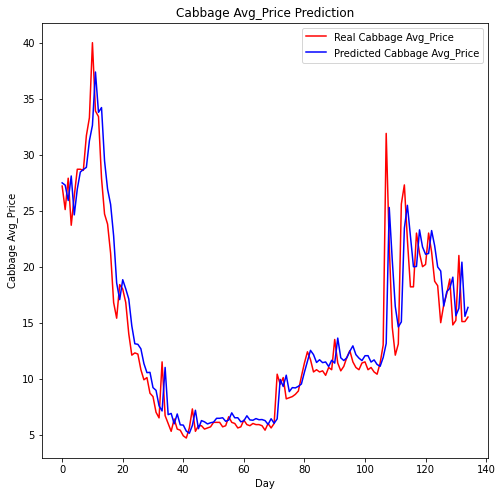

In [46]:
# Visualising the results
plt.figure(figsize=(8,8))
plt.plot(real_stock_price, color = 'red', label = 'Real Cabbage Avg_Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Cabbage Avg_Price')
plt.title('Cabbage Avg_Price Prediction')
plt.xlabel('Day')
plt.ylabel('Cabbage Avg_Price')
plt.legend()
plt.show()